In [1]:
# Imports
import numpy as np
import random
from tqdm.notebook import tqdm
import sys
from common import DATA
import scipy.stats as stats
import matplotlib.pyplot as plt
import Baselines
from utils import *

from Baselines import *
 
sys.setrecursionlimit(10**6)

Loading dataset: epinions
Keeping top 10 items.


Computing jaccard indexes:   0%|          | 0/2026 [00:00<?, ?it/s]

Loading dataset: filmtrust
Keeping top 10 items.


Computing jaccard indexes:   0%|          | 0/1044 [00:00<?, ?it/s]

In [54]:
# Combining item jaccard and item difference
def item_similarity_recommender(alpha=0.1):
    def recommender(data, item, test_points):
        rb = set(data['rated_by'][item])
        recommendations = {n : data['ratings'][n][item] for n in rb}
        
        for node in test_points: # loop through nodes which need recommendation
            similarity_vals = [0 for _ in range(5)]
            for o_v in data['trust_graph']:
                if o_v == node:
                    continue
                if o_v in recommendations:
                    similarity_vals[recommendations[o_v] - 1] += alpha*(data['item_jaccard'][node][o_v]) + (1-alpha)*(data['item_jaccard'][node][o_v])
            
            recommendations[node] = np.argmax(similarity_vals) + 1

            if np.max(similarity_vals) == 0:
                recommendations[node] = random.choice([1,2,3,4,5])
                
        return recommendations
    return recommender

def intra_item_majority(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['rating'][n][item] for n in rb}
    
    for node in test_points: # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph'][node]:
            if o_v == node:
                continue
            for o_item, rating in data['ratings'][o_v].items():
                similarity_vals[rating - 1] += data['item_sims'][item][o_item]
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

# Weighted average version
def intra_item_WA(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in test_points: # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in graph[node]:
            if o_v == node:
                continue
            for o_item, rating in data['ratings'][o_v].items():
                similarity_vals[rating - 1] += TOP_100_ITEM_SIMS[item][o_item]
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations


def item_jaccard_recommender(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[recommendations[o_v] - 1] += (ITEM_JACCARDS[node - 1, o_v - 1])
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def item_rating_diff_recommender(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[recommendations[o_v] - 1] += data['item_jaccard'][node][o_v]
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations


def item_rating_diff_recommender_new(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                s = 0
                intr = (set(data['ratings'][o_v].keys()).intersection(set(data['ratings'][node].keys()) - {item}))
                for i in intr:
                    s += 1 - (abs(data['ratings'][o_v][i] - data['ratings'][node][i])/4)
                    
                s /= max(len(intr), 1)
                similarity_vals[recommendations[o_v] - 1] += s
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def weighted_item_diffs_new(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                s = 0
                intr = (set(data['ratings'][o_v].keys()).intersection(set(data['ratings'][node].keys()) - {item}))
                for i in intr:
                    s += (1-(abs(data['ratings'][o_v][i] - data['ratings'][node][i])/4)) * TOP_100_ITEM_SIMS[item][i]
                    
                s /= max(len(intr), 1)
                similarity_vals[recommendations[o_v] - 1] += s
        
        recommendations[node] = np.argmax(similarity_vals) + 1
        print(similarity_vals)
        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def weighted_item_diffs(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                WID = WEIGHTED_ITEM_DIFFS[str(node)][str(o_v)]
                if str(item) in WID:
                    similarity_vals[recommendations[o_v] - 1] += WID[str(item)]
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

# Weighted average version
def item_rating_diff_recommender_WA(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[recommendations[o_v] - 1] += (1 - ITEM_DIFFS[node - 1, o_v - 1])
        
        sorted_vals = sorted(filter(lambda x: x[0] > 0.2, zip(similarity_vals, [1,2,3,4,5])), key=lambda x: x[0], reverse=True)
        
        recommendations[node] = round(np.average([x[1] for x in sorted_vals[:5]], weights=[x[0] for x in sorted_vals[:5]]))
        

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def jaccard_majority_of_majorities(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[recommendations[o_v] - 1] += (data['jaccard_idx'][node][o_v])
        recommendations[node] = np.argmax(similarity_vals) + 1
        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])

    return recommendations

def jaccard_weighted_neighbours(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in graph[node]:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[recommendations[o_v] - 1] += (data['jaccard_idx'][node][o_v])
        recommendations[node] = np.argmax(similarity_vals) + 1
        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])

    return recommendations

def mode_of_neighbours(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        ratings = []
        for neighbour in graph[node]:
            if neighbour in recommendations:
                ratings.append(recommendations[neighbour])
        
        if len(ratings) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
        else:
            recommendations[node] = stats.mode(ratings)[0][0]

    return recommendations

def mean_of_neighbours(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        ratings = []
        for neighbour in graph[node]:
            if neighbour in recommendations:
                ratings.append(recommendations[neighbour])
        
        if len(ratings) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
        else:
            recommendations[node] = np.mean(ratings)

    return recommendations

def median_of_neighbours(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        ratings = []
        for neighbour in graph[node]:
            if neighbour in recommendations:
                ratings.append(recommendations[neighbour])
        
        if len(ratings) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
        else:
            recommendations[node] = np.median(ratings)

    return recommendations

def jaccard_intra_item(data, item, test_points):
    rb = set(data['rated_by'][item])
    recommendations = {n : data['ratings'][n][item] for n in rb}
    
    for node in test_points: # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in data['trust_graph']:
            if o_v == node:
                continue
            for o_item, rating in data['ratings'][o_v].items():
                similarity_vals[rating - 1] += JACCARD_MATRIX[node -1, o_v -1]*(TOP_100_ITEM_SIMS[item][o_item])
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def jaccard_item_rating(alpha=0.1):
    def recommender(data, item, test_points):
        rb = set(data['rated_by'][item])
        recommendations = {n : data['ratings'][n][item] for n in rb}
        
        for node in test_points: # loop through nodes which need recommendation
            similarity_vals = [0 for _ in range(5)]
            for o_v in data['trust_graph']:
                if o_v == node:
                    continue
                if o_v in recommendations:
                    similarity_vals[recommendations[o_v] - 1] += alpha*(data['jaccard_idx'][node][o_v]) + (1-alpha)*(data['item_jaccard'][node][o_v])
            
            recommendations[node] = np.argmax(similarity_vals) + 1

            if np.max(similarity_vals) == 0:
                recommendations[node] = random.choice([1,2,3,4,5])
                
        return recommendations
    return recommender

def jaccard_item_rating_power_scaling(alpha=1):
    def recommender(data, item, test_points):
        rb = set(data['rated_by'][item])
        recommendations = {n : data['ratings'][n][item] for n in rb}
        
        for node in test_points: # loop through nodes which need recommendation
            similarity_vals = [0 for _ in range(5)]
            for o_v in data['trust_graph']:
                if o_v == node:
                    continue
                if o_v in recommendations:
                    similarity_vals[recommendations[o_v] - 1] += max(data['jaccard_idx'][node][o_v]**(1/alpha), data['item_jaccard'][node][o_v])
            
            recommendations[node] = np.argmax(similarity_vals) + 1

            if np.max(similarity_vals) == 0:
                recommendations[node] = random.choice([1,2,3,4,5])
                
        return recommendations
    return recommender

# def JWIR_recommender(data, item, test_points):
#     rb = set(data['rated_by'][item])
#     recommendations = {n : data['ratings'][n][item] for n in rb}
    
#     for node in test_points: # loop through nodes which need recommendation
#         similarity_vals = [0 for _ in range(5)]
#         for o_v in data['trust_graph']:
#             if o_v == node:
#                 continue
#             if o_v in recommendations:
#                 WID = WEIGHTED_ITEM_DIFFS[str(node)][str(o_v)]
#                 if str(item) in WID:
#                     similarity_vals[recommendations[o_v] - 1] += max(data['jaccard_idx'][node][o_v], WEIGHTED_ITEM_DIFFS[str(node)][str(o_v)][str(item)])
        
#         recommendations[node] = np.argmax(similarity_vals) + 1

#         if np.max(similarity_vals) == 0:
#             recommendations[node] = random.choice([1,2,3,4,5])
            
#     return recommendations

In [55]:
# Goals
# 1. Confine graph to those who have rated top 5
# 2. Make predictions with only information about graph structure and other's ratings
#       - This means using intra-item similarities from other users

# Need to make our comparisons more similar
# So restrict the nodes to only those who have voted the first node, don't test across items [DONE]

# Think about other ways to approach the argmax, one example is the weighted average, we can cut off the outlier small ratings [DONE]

# Take a trustwalker approach/Random walk with the intra-item data [DONE]

# NEXT STEPS
# Connecting item graph with intra-item diff, i.e. weighted sum [DONE]
# Connecting item graph with jaccard graph, i.e. random walk methods
# Next steps -> Combine item-based network with intra-item, similar to how we did with social network/intra item
#               -> Finally we will combine our understanding of these 

In [56]:
results = {}

In [57]:
# Make dict to hold results
tests = {
    # 'weighted rating difference': weighted_item_diffs,
    # 'JWIR difference MoM (Max)': JWIR_recommender,
    # 'intra-item MoM': intra_item_majority,
    # 'jaccard intra-item MoM': jaccard_intra_item,
    # 'item-rating difference MoM': item_rating_diff_recommender,
    # 'jaccard item-rating difference MoM (Max)': jaccard_item_rating_power_scaling(1),
    # 'jaccard weighted item-rating diff Max': JWIR_recommender,
    # 'jaccard item-rating difference MoM (Addition, a=0.5)': jaccard_item_rating(alpha=0.5),
    # 'jaccard item-rating difference MoM (Multiplication)': jaccard_item_rating_test_1(alpha=0.5),
    #'jaccard item-rating difference MoM (Max, power scaling)': jaccard_item_rating_test(alpha=0.5),
    # 'item-jaccard MoM': item_jaccard_recommender,
    # 'trust based jaccard': jaccard_recommender,
    # 'trust walk': trust_walk_recommender,
    # 'jaccard MoM': jaccard_majority_of_majorities,
    'item_diff new': item_rating_diff_recommender_new,
    'weighted_item_diffs_new': weighted_item_diffs_new,
    # 'similarity recommender': item_similarity_recommender,
    # 'jaccard weighted neighbours': jaccard_weighted_neighbours,
    'mode of neighbours': mode_of_neighbours,
    # 'monte-carlo random walk': random_walk_mc,
    # 'jaccard MC random walk': jacc_random_walk_mc,
    # 'median of neighbours': median_of_neighbours,
    # 'mean of neighbours': mean_of_neighbours,
    'random': Baselines.random_recommender,
    'universal random': Baselines.universal_recommender,
}

# Top 5 items
ITEMS = ORDERED_ITEMS[:5]

reduced_graph, reduced_ratings, reduced_rated_by = remove_non_voters(TRUST_GRAPH, RATINGS, RATED_BY, ITEMS)

for k, recommender in tqdm(tests.items()):
    if k in results:
        continue
    sample_sizes, accs, mses, mes = [], [], [], [] 
    for i in ITEMS: 
        for _ in range(25): # run 5 times for each item
            acc, mse, me = evaluate(recommender, reduced_graph, reduced_ratings, reduced_rated_by, i, 0.15) # remove 15% of ratings
            accs.append(acc), mses.append(mse), mes.append(me)

    results[k] = {
        'sample_sizes': sample_sizes,
        'acc': accs,
        'mse': mses,
        'me': mes
    }

  0%|          | 0/5 [00:00<?, ?it/s]

[-0.21833766849595115, -0.2571532540063424, -0.20378182392955438, -0.17952208298555983, -0.07277922283198368]
[-3.054921149115584, -3.3141265799496336, -2.758686371019527, -2.499480940185477, -1.6292912795283103]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.017784496443938397, 0.0161377838102404, 0.00944115243320187, 0.00845312485298307, 0.007025973903778137]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[-2.8587847670853472, -3.3335883020485144, -2.7903444482352358, -2.4489092814697804, -1.685661934900682]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.02195616844930666, 0.017016030548212664, 0.009880275802188004, 0.009770494959941471, 0.009002029064215739]
[0.01262479685835133, 0.012515016016104798, 0.007025973903778136, 0.005928165481312802, 0.004720576216600935]
[0.0, 0.0, 0.0, 0.0, 0.0]
[-2.814230391912539, -3.1474945172706033, -2.6290836556025026, -2.3698782247684536, -1.4626592168492796]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 

/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_3527/553952959.py:243: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  recommendations[node] = stats.mode(ratings)[0][0]


In [51]:
import colorsys
N = len(results)
HSV_tuples = [(x*1.0/N, 0.85, 0.7) for x in range(N)]
RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
random.shuffle(RGB_tuples)

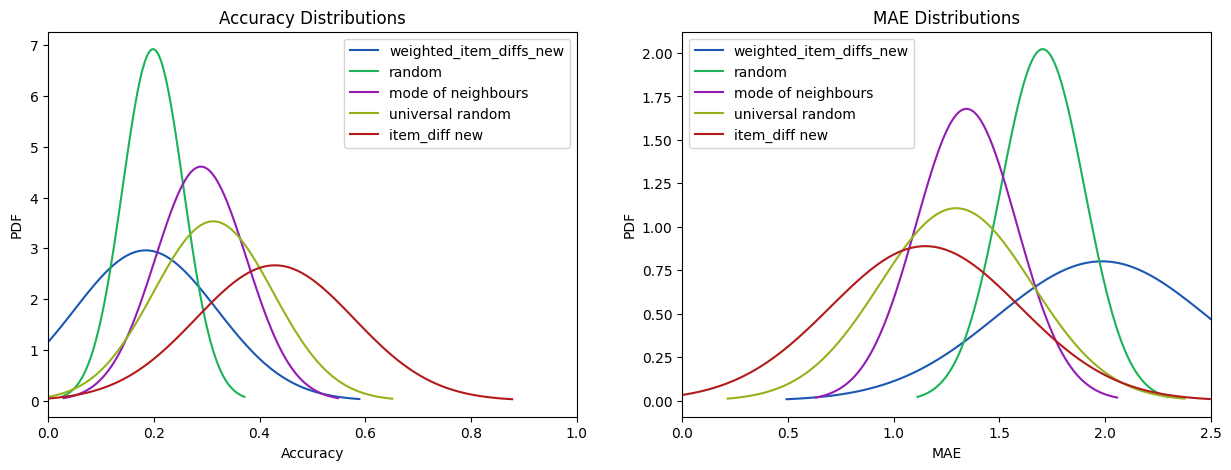

In [53]:
fig = plt.figure(figsize=(15, 5))

# plt.subplot(5,1,1)
# plt.title("Mean squared error")
# for i, (name, res) in enumerate(results.items()):
#     plt.plot(res['sample_sizes'], np.median(res['mse'], axis=1), label=name, color=RGB_tuples[i])
#     for x, y in zip(res['sample_sizes'], res['mse']):
#         plt.plot(x, min(y), marker='o', markersize=2, color=RGB_tuples[i])
#         plt.plot(x, max(y), marker='o',  markersize=2, color=RGB_tuples[i])
# plt.legend()
# plt.ylabel("MSE")
# plt.xlabel("Ratio of sample to recommend for")

# plt.subplot(5,1,2)
# plt.title("Mean Absolute Error")
# for i, (name, res) in enumerate(results.items()):
#     plt.plot(res['sample_sizes'], np.median(res['me'], axis=1), label=name, color=RGB_tuples[i])
#     for x, y in zip(res['sample_sizes'], res['me']):
#         plt.plot(x, min(y), marker='o', markersize=2, color=RGB_tuples[i])
#         plt.plot(x, max(y), marker='o',  markersize=2, color=RGB_tuples[i])
# plt.legend()
# plt.ylabel("MAE")
# plt.xlabel("Ratio of sample to recommend for")

# plt.subplot(5,1,3)
# plt.title("Accuracy")
# for i, (name, res) in enumerate(results.items()):
#     plt.plot(res['sample_sizes'], np.median(res['acc'], axis=1), label=name, color=RGB_tuples[i])
#     for x, y in zip(res['sample_sizes'], res['acc']):
#         plt.plot(x, min(y), marker='o', markersize=2, color=RGB_tuples[i])
#         plt.plot(x, max(y), marker='o',  markersize=2, color=RGB_tuples[i])
# plt.legend()
# plt.ylabel("ACC")
# plt.xlabel("Ratio of sample to recommend for")

plt.subplot(1,2,1)
plt.title("Accuracy Distributions")
plt.xlim(0, 1)
result_items = sorted(list(results.items()), key=lambda x: np.mean(x[1]['acc']))

for i, (name, res) in enumerate(result_items):
    mu = np.mean(res['acc'])
    sigma = np.std(res['acc'])
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=name, color=RGB_tuples[i])
plt.legend()
plt.ylabel("PDF")
plt.xlabel("Accuracy")

plt.subplot(1,2,2)
plt.xlim(0, 2.5)
plt.title("MAE Distributions")
for i, (name, res) in enumerate(result_items):
    mu = np.mean(res['me'])
    sigma = np.std(res['me'])
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=name, color=RGB_tuples[i])
plt.legend()
plt.ylabel("PDF")
plt.xlabel("MAE")

plt.show()

In [ ]:
similarity_results = {}
for alpha in np.arange(0, 1, 0.05):
    sample_sizes, accs, mses, mes = [], [], [], [] 
    for i in ITEMS: 
        for _ in range(5): # run 5 times for each item
            acc, mse, me = evaluate(jaccard_item_rating_power_scaling(alpha), reduced_graph, reduced_ratings, reduced_rated_by, i, 0.15) # remove 15% of ratings
            accs.append(acc), mses.append(mse), mes.append(me)
    similarity_results[alpha] = {'acc': accs, 'mse': mses, 'me': mes}
    
mean_res = {alpha:np.mean(data['acc']) for alpha, data in similarity_results.items()}

/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_8717/3786584802.py:317: RuntimeWarning: divide by zero encountered in scalar divide
  similarity_vals[recommendations[o_v] - 1] += max(JACCARD_MATRIX[node - 1, o_v - 1]**(1/alpha), ITEM_DIFFS_NEW[str(node)][str(o_v)])


Text(0, 0.5, 'Accuracy')

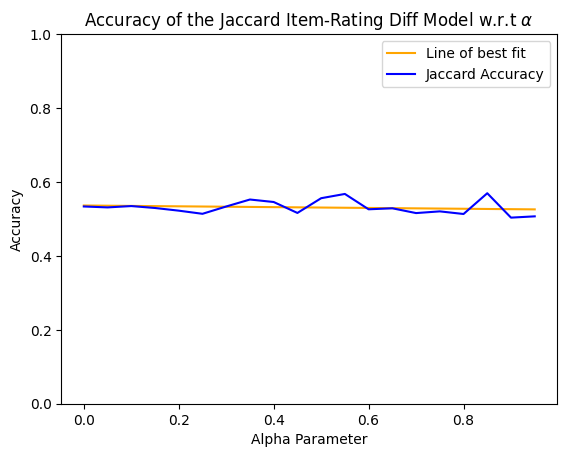

In [ ]:
y, x = np.array(list(mean_res.values())), np.array(list(mean_res.keys()))

plt.title('Accuracy of the Jaccard Item-Rating Diff Model w.r.t $\\alpha$')

a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b, label='Line of best fit', color='orange')

plt.plot(x, y, label='Jaccard Accuracy', color='blue')
plt.ylim(0, 1)

plt.legend()

plt.xlabel('Alpha Parameter')
plt.ylabel('Accuracy')

In [ ]:
x_ind = np.random.random_integers(0, len(JACCARD_MATRIX) - 1, 100000)
y_ind = np.random.random_integers(0, len(JACCARD_MATRIX) - 1, 100000)

points = JACCARD_MATRIX[x_ind, y_ind]

transformed_matrix_power = np.power(points, 0.05)
min_val = np.min(transformed_matrix_power)
max_val = np.max(transformed_matrix_power)
transformed_matrix_power = (transformed_matrix_power - min_val) / (max_val - min_val)

/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_93530/3312450591.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 49288 + 1) instead
  x_ind = np.random.random_integers(0, len(JACCARD_MATRIX) - 1, 100000)
/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_93530/3312450591.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 49288 + 1) instead
  y_ind = np.random.random_integers(0, len(JACCARD_MATRIX) - 1, 100000)


In [2]:
vals = [v for val in ITEM_DIFFS_NEW.values() for v in val.values()]

Text(0.5, 0.98, 'Distributions of Item-Difference and Jaccard Similarities')

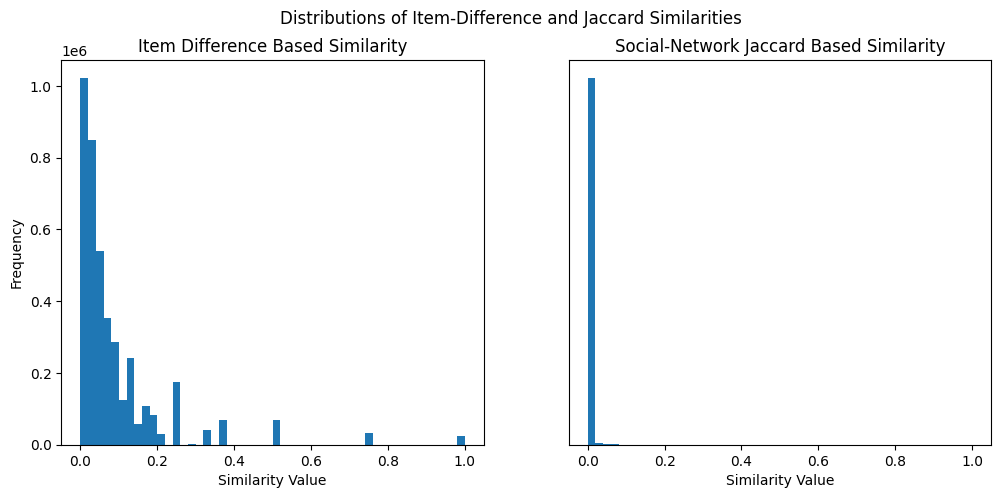

In [ ]:

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.title("Item Difference Based Similarity")
plt.hist(vals, bins=50)
plt.ylabel("Frequency")
plt.xlabel("Similarity Value")

plt.subplot(1,2,2)
plt.title("Social-Network Jaccard Based Similarity")
plt.hist(points, bins=50)
plt.yticks([])
plt.xlabel("Similarity Value")

plt.suptitle("Distributions of Item-Difference and Jaccard Similarities")

(0.0, 1.0)

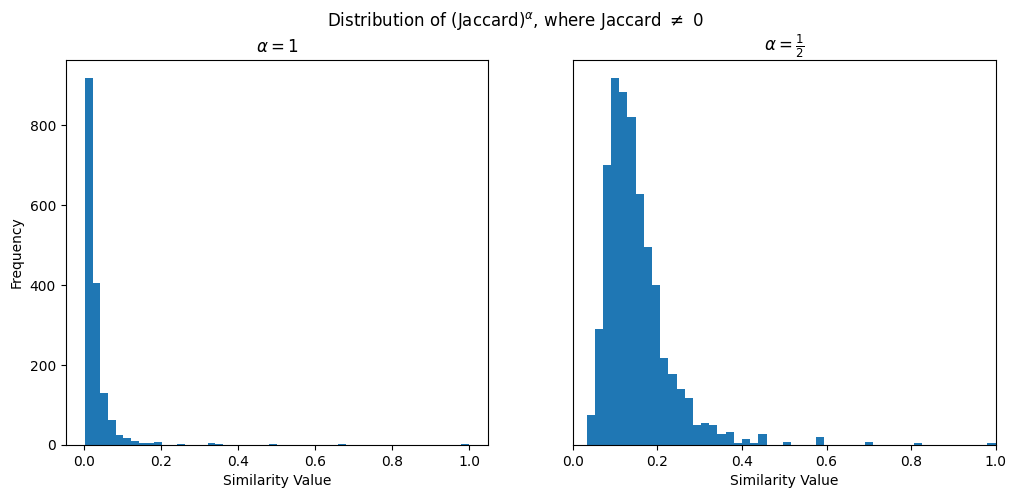

In [ ]:
plt.figure(figsize=(12, 5))
NZ_points = points[points != 0]

plt.subplot(1,2,1)
plt.title("$\\alpha = 1$")
plt.hist(NZ_points, bins=50)
plt.ylabel("Frequency")
plt.xlabel("Similarity Value")

plt.subplot(1,2,2)
plt.title("$\\alpha = \\frac{1}{2}$")
plt.hist(np.power(NZ_points, 1/2), bins=50)
plt.yticks([])
plt.xlabel("Similarity Value")

plt.suptitle("Distribution of (Jaccard)$^\\alpha$, where Jaccard $\\neq$ 0")
plt.xlim(0, 1)